<a href="https://colab.research.google.com/github/junsookim76/MD_Lecture/blob/main/TRAJ_DNA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 코드로 형식 지정됨
```

# Radius Calculation

### This program reads .xtc file for analysis.

### 1. First calculate the coordinates of C.O.M.s of base pairs. Also write .gro and .xtc files.

### * .xtc file has to be "fitted to the initial" ignoring translation + rotation.

In [ ]:
import mdtraj as md
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
def set_fig():

    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=40)
    plt.rc('axes', labelsize=60) # fontsize of the x and y labels

#    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(right=0.95)

    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)


    ax.tick_params(which='major', bottom=True, top=True, left=True, right=True, length=15, width=3, direction="in", pad=20)
    ax.tick_params(which='minor', bottom=True, top=True, left=True, right=True, length=10, width=3, direction="in", pad=20)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)

### 1. List of File Names
#### - Confirm the file names before starting the analysis

In [ ]:
# name for input file .gro
input_gro="./conf_DNA.gro"

# name for input file .xtc
input_xtc="./traj_DNA_fit_1st_dt_1ns.xtc"


### 2. Read .xtc File and the Topology Info

In [ ]:
# Read .xtc File with .gro File
xtc=md.load_xtc(input_xtc,top=input_gro)

In [ ]:
# natoms: number of atoms
natoms=xtc.n_atoms

# nbase: number of bases
nbase=xtc.n_residues

# nstrand: number of DNA strands
nstrand=4

# nbp: number of base pairs
nbp=round(nbase/nstrand)
ncirc = 2
print(nbp)

82


In [ ]:
# Topological Information

top=xtc.topology

table, bonds=top.to_dataframe()

atomname=table.values[:,1]
element = table.values[:,2]
i=0
for ii in atomname:
    #print(i[0])
    element[i] = ii[0]
    i += 1
print(element)
print(table)
print(atomname[:64])

['P' 'O' 'O' ... 'H' 'H' 'O']
       serial  name element  resSeq resName  chainID segmentID
0           1     P       P       1      DA        0          
1           2   OP1       O       1      DA        0          
2           3   OP2       O       1      DA        0          
3           4   O5'      VS       1      DA        0          
4           5   C5'      VS       1      DA        0          
...       ...   ...     ...     ...     ...      ...       ...
10491   10492   H3'      VS      82      DT        0          
10492   10493   C2'      VS      82      DT        0          
10493   10494  H2'1      VS      82      DT        0          
10494   10495  H2'2      VS      82      DT        0          
10495   10496   O3'      VS      82      DT        0          

[10496 rows x 7 columns]
['P' 'OP1' 'OP2' "O5'" "C5'" "H5'1" "H5'2" "C4'" "H4'" "O4'" "C1'" "H1'"
 'N9' 'C8' 'H8' 'N7' 'C5' 'C6' 'N6' 'H61' 'H62' 'N1' 'C2' 'H2' 'N3' 'C4'
 "C3'" "H3'" "C2'" "H2'1" "H2'2" "O3'" 'P'

In [ ]:
# xtc.xyz[프레임, 입자, xyz]
xtc.xyz[:,:,:].shape

(2001, 10496, 3)

In [ ]:
nsteps=np.size(xtc.xyz[:,0,0])
print('nsteps = %d'%nsteps)

nsteps = 2001


### 3. Atomic Masses and Base Pair Masses
#### - at_mass: atomic mass (array of natoms)
#### - bp_mass: base pair mass (array of nbp)
#### - tot_mass: total mass of double-stranded DNA (a single value)

In [ ]:
# Initialization
at_mass=np.zeros(natoms)    # mass of each atom
bp_mass=np.zeros(ncirc*nbp) # mass of each base pairs
tot_mass=0.0                # mass of total atoms

ires=0     # Counting base(residue) numbers one by one
ic=0       # for counting purposes, but no physical significance

for i in range(natoms):
    an1=atomname[i]
    if an1 == 'P':
        at_mass[i]=30.970
        ires += 1
        if ires <= nbp:
            ibp = ires - 1
        elif ires <= 2*nbp:
            ibp = -ires + 2*nbp
        elif ires <= 3*nbp:
            ibp = ires - nbp -1
        else:
            ibp = -ires + 5*nbp
        # print(' - %f  - %f'%(ibp,ires))
    elif (an1 == "C"):
        at_mass[i]=12.010
    elif (an1 == "O"):
        at_mass[i]=16.000
    elif (an1 == "N"):
        at_mass[i]=14.010
    else:
        at_mass[i]=1.008

    bp_mass[ibp]=bp_mass[ibp]+at_mass[i]
    tot_mass=tot_mass+at_mass[i]

    ic+=1

# We check if the total_mass and bp_mass are calculated correctly
# by calculating the total_mass as the sum of bp_mass.

mass_minicirc = 0
for ibp in range(nbp):
    mass_minicirc = mass_minicirc + bp_mass[ibp]

print("number of atoms = %s" % ic)
print("total catenane   mass = %s" % tot_mass)
print("total minicircle mass = %s" % mass_minicirc)

number of atoms = 10496
total catenane   mass = 20407.50400000196
total minicircle mass = 10203.751999999986


### 4. Calculating distance between the CoMs of two minicircles

In [ ]:
com = np.zeros((np.size(xtc.xyz[0,:,0]),3), dtype=float)

natoms_minicircle1 = int(np.size(xtc.xyz[0,:,0]) / 2)
print('Number of atoms in minicircle 1 = %d'%natms_minicircle1)

distance_minicirc = np.zeros(nsteps, dtype=float)

for istep in range (nsteps):

    if istep %100 == 0:
        print('Step = %d'%istep)
    com[:,0] = xtc.xyz[istep,:,0]*at_mass
    com[:,1] = xtc.xyz[istep,:,1]*at_mass
    com[:,2] = xtc.xyz[istep,:,2]*at_mass

    #print(com)

    com_minicircle1 = np.sum(com[:natoms_minicircle1], axis=0) / mass_minicirc
    if istep %100 == 0:
            print('  CoM of Minicircle 1 (nm) = %s'%com_minicircle1)
    com_minicircle2 = np.sum(com[natoms_minicircle1:], axis=0) / mass_minicirc
    if istep %100 == 0:
        print('  CoM of Minicircle 2 (nm) = %s'%com_minicircle2)

    distance_minicirc[istep] = np.linalg.norm(com_minicircle2 - com_minicircle1)
    if istep %100 == 0:
        print('  Distance between two minicircles (nm) = %f'%distance_minicirc[istep])


Number of atoms in minicircle 1 = 5248
Step = 0
  CoM of Minicircle 1 (nm) = [12.55546174 14.54706342  6.90608716]
  CoM of Minicircle 2 (nm) = [16.79331674 14.79047343  6.93772388]
  Distance between two minicircles (nm) = 4.244958
Step = 100
  CoM of Minicircle 1 (nm) = [12.55104959 14.54527575  6.90398702]
  CoM of Minicircle 2 (nm) = [16.62894129 15.23589086  6.33514495]
  Distance between two minicircles (nm) = 4.174893
Step = 200
  CoM of Minicircle 1 (nm) = [12.54993556 14.54840578  6.90487746]
  CoM of Minicircle 2 (nm) = [17.19542525 15.15101498  6.96448313]
  Distance between two minicircles (nm) = 4.684791
Step = 300
  CoM of Minicircle 1 (nm) = [12.55267342 14.54482473  6.90561252]
  CoM of Minicircle 2 (nm) = [15.72980177 14.64133284  4.18194219]
  Distance between two minicircles (nm) = 4.185910
Step = 400
  CoM of Minicircle 1 (nm) = [12.55254303 14.54542337  6.90703815]
  CoM of Minicircle 2 (nm) = [16.34110326 14.72458465  4.56764828]
  Distance between two minicircles

In [ ]:
print('Average distance (nm) = %f'%(np.mean(distance_minicirc)))

Average distance (nm) = 4.352223


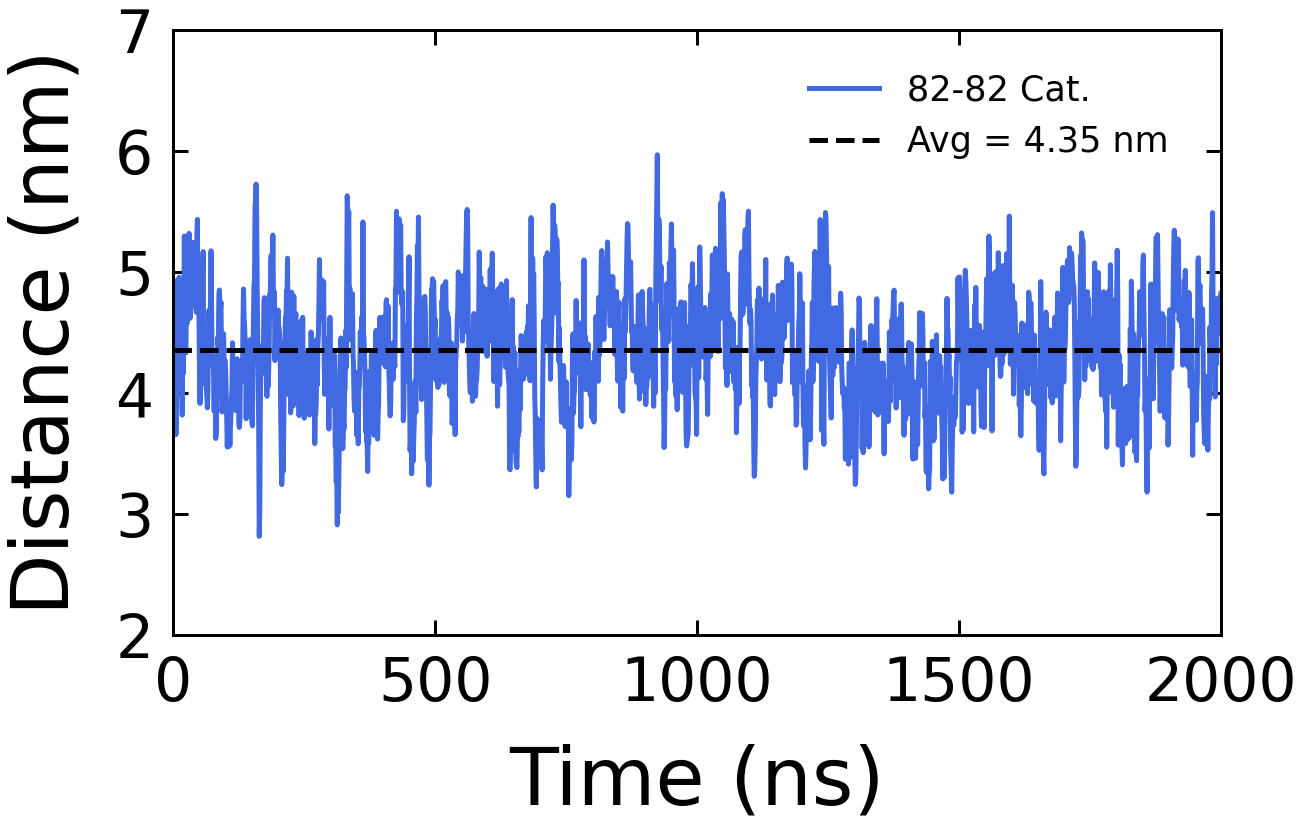

In [ ]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(np.arange(0, 2001, 1), distance_minicirc, label='82-82 Cat.', color='royalblue', linewidth=5)

plt.hlines(np.mean(distance_minicirc), 0, 2000, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Time (ns)', labelpad=30, fontsize=80)
plt.ylabel('Distance (nm)', labelpad=30, fontsize=80)

plt.xlim(0, 2000)
plt.ylim(2.5, 6.5)

plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(2.0, 7.01, 1.0))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.98,0.98), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('distance_com.png')


### 5. Distribution of the distance between the CoMs of two minicircles

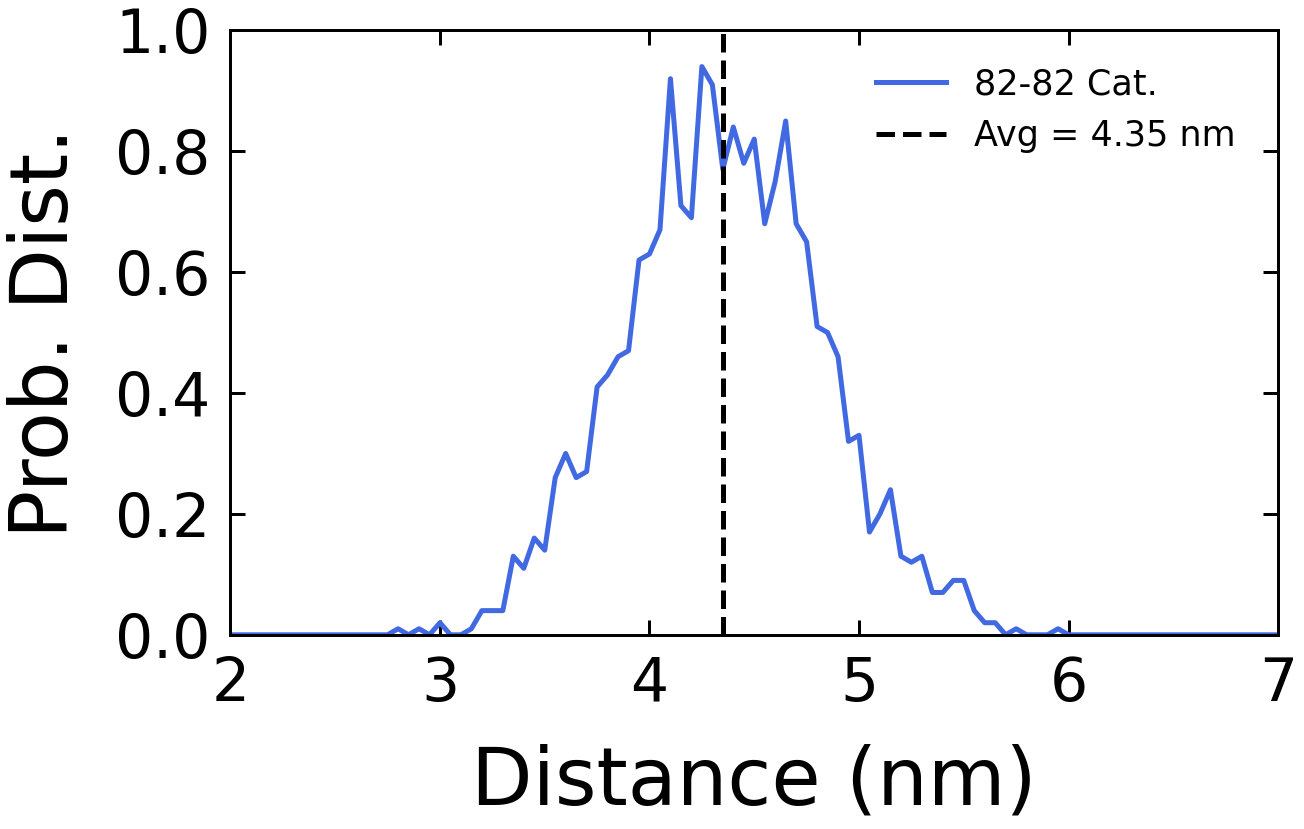

In [ ]:
width = 0.05
width_2 = width * 0.5
init  = 2.0
fin   = 7.0
fin_i = int((fin - init)/width + 1.0)
distrb_x = np.arange(init, fin+width, width)
distrb_y = np.zeros(fin_i, dtype=float)

distrb_com = np.trunc((distance_minicirc + width_2 - init) / width)
for i in range (fin_i):
    distrb_y[i] += np.count_nonzero(distrb_com == i)

distrb_y /= nsteps*width

fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(distrb_x, distrb_y, label='82-82 Cat.', color='royalblue', linewidth=5)

plt.vlines(np.mean(distance_minicirc), 0, 1, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Distance (nm)', labelpad=30, fontsize=80)
plt.ylabel('Prob. Dist.', labelpad=30, fontsize=80)

plt.xlim(2, 7)
plt.ylim(0, 1)

plt.xticks(np.arange(2.0, 7.1, 1))
plt.yticks(np.arange(0, 1.1, .2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.99,0.99), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('prob_distrb_distance_com.png')


In [ ]:
def gauss(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

In [ ]:
x0 = distrb_x
y0 = distrb_y

popt0, pcov0 = curve_fit(gauss, x0, y0)

residuals0 = x0 - gauss(x0, *popt0)
ss_res0 = np.sum(residuals0**2)
ss_tot0 = np.sum((y0-np.mean(y0))**2)
r_squared0 = 1 - (ss_res0 / ss_tot0)

print('82-82 bp  : y = %f*np.exp(-(x-%f)**2/(2*%f**2)) --> R^2 = %f \n'
          % (popt0[0], popt0[1], popt0[2], r_squared0))

82-82 bp  : y = 0.854223*np.exp(-(x-4.349947)**2/(2*0.467821**2)) --> R^2 = -251.518675 



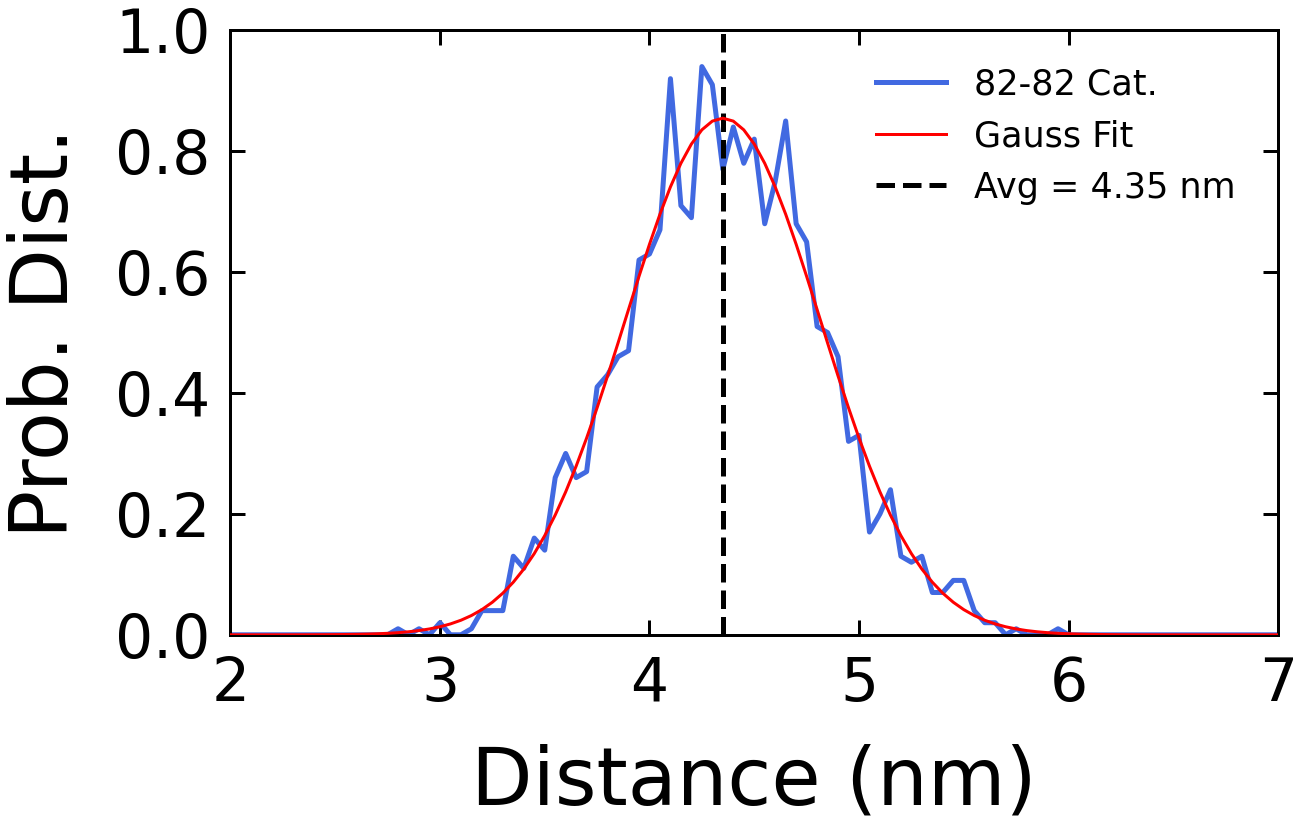

In [ ]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(distrb_x, distrb_y, label='82-82 Cat.', color='royalblue', linewidth=5)

ax.plot(x0, gauss(x0, *popt0), linewidth= 3, color='red', zorder=5, label='Gauss Fit')

plt.vlines(np.mean(distance_minicirc), 0, 1, linewidth=5, linestyle='--', color='black', zorder = 3, label='Avg = %.2f nm'%np.mean(distance_minicirc))

plt.xlabel('Distance (nm)', labelpad=30, fontsize=80)
plt.ylabel('Prob. Dist.', labelpad=30, fontsize=80)

plt.xlim(2, 7)
plt.ylim(0, 1)

plt.xticks(np.arange(2.0, 7.1, 1))
plt.yticks(np.arange(0, 1.1, .2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.99,0.99), prop={'size': 35}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('prob_distrb_distance_com_w_fit.png')


### 6. Time correlation of the distance between the CoMs of two minicircles

In [ ]:
def exp_dec(x, a):
    return np.exp(-(x)/(a))

In [ ]:
corr_time = 21 # ns

distance_for_corr = distance_minicirc -np.mean(distance_minicirc)
corr = np.zeros(corr_time, dtype=float)

for istep in range(nsteps - corr_time):
    for icorr in range (corr_time):
        corr[icorr] += distance_for_corr[istep] * distance_for_corr[istep+icorr]

corr /= (nsteps-corr_time)

corr /= corr[0]
#print(corr)


In [ ]:
x1 = np.arange(0, corr_time, 1)
y1 = corr

popt1, pcov1 = curve_fit(exp_dec, x1, y1)

residuals1 = x1 - exp_dec(x1, *popt1)
ss_res1 = np.sum(residuals1**2)
ss_tot1 = np.sum((y0-np.mean(y1))**2)
r_squared1 = 1 - (ss_res1 / ss_tot1)

print('82-82 bp  : y = np.exp(-x/%f) --> R^2 = %f \n'
          % (popt1[0], r_squared1))


82-82 bp  : y = np.exp(-x/3.833344) --> R^2 = -340.249694 



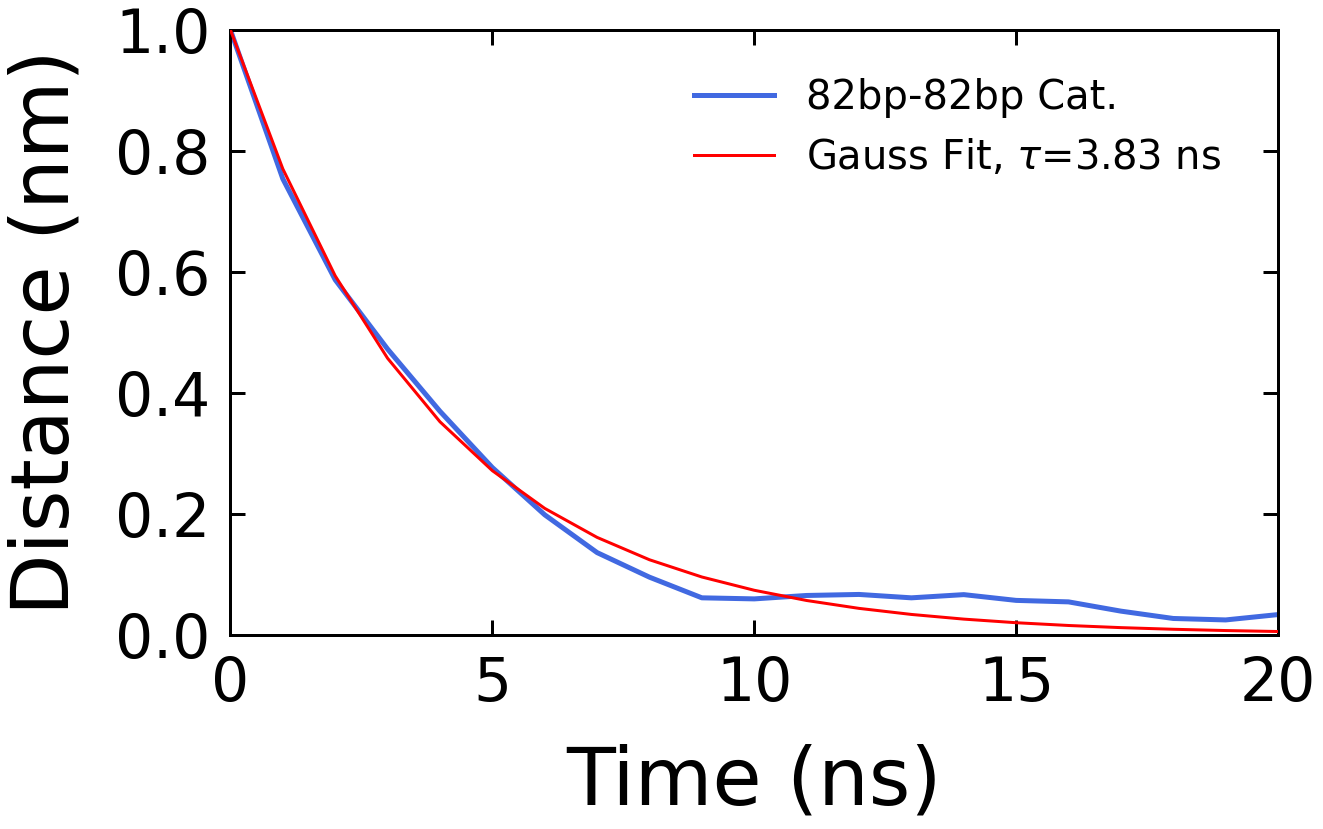

In [ ]:
fig, ax = plt.subplots(figsize=(19.4, 12))

plt.plot(np.arange(0, corr_time, 1), corr, label='82bp-82bp Cat.', color='royalblue', linewidth=5)

ax.plot(x1, exp_dec(x1, *popt1), linewidth= 3, color='red', zorder=5, label=r'Gauss Fit, $\tau$=%.2f ns'%popt1[0])

#plt.hlines(0.5, 0, popt0[0], linewidth=2, linestyle='--', color='black', zorder = 1)
#plt.vlines(popt0[0], 0, 0.5, linewidth=2, linestyle='--', color='black', zorder = 1)

plt.xlabel('Time (ns)', labelpad=30, fontsize=80)
plt.ylabel('Distance (nm)', labelpad=30, fontsize=80)

plt.xlim(0, 20)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(0.0, 1.01, 0.2))

set_fig()

ax.legend(loc='upper right',edgecolor='none',bbox_to_anchor=(0.98,0.98), prop={'size': 40}, framealpha=0)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.95)
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(right=0.95)

# output_histz1_pdf="data_hist_z.pdf"
#plt.show()
plt.savefig('time_corr_distance_com_w_fit.png')

#plt.savefig('dist_8282_com_curv.pdf')